# U Net Example

First, import the necessary modules

In [38]:
import torch.nn as nn
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import numpy as np
from torchvision import transforms
import matplotlib.pyplot as plt


Then, check if your code runs on GPU, if not, adjust the settings accordingly.

In [39]:
# Check if GPU is available
if torch.cuda.is_available():
    print("The code will run on GPU.")
else:
    print("The code will run on CPU. Go to Edit->Notebook Settings and choose GPU as the hardware accelerator")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

The code will run on GPU.


Mount the google drive so you can access the data.

In [40]:
from google.colab import drive
# This will prompt for authorization.

drive.mount('/content/drive/')
!ls '/content/drive/'

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).
MyDrive  Othercomputers


## Loading the Data

- define a custom dataset
- load the image and mask data according to how it is saved on your drive
- make sure that masks and images are aligned

In [50]:
class CellSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None, max_samples=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.image_files = os.listdir(image_dir)
        self.transform = transform

        # optional: limit the number of files loaded
        if max_samples:
            self.image_files = self.image_files[:max_samples]

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        # path structure to images and masks: make sure they correspond!
        image_path = os.path.join(self.image_dir, self.image_files[idx])
        mask_path = os.path.join(self.mask_dir, self.image_files[idx]).replace(".png", "_M.png")

        image = Image.open(image_path).convert("L")  # grayscale images
        mask = Image.open(mask_path).convert("L")

        if self.transform:
            image = self.transform(image)
            mask = self.transform(mask)

        return image, mask

Initialize dataloader and dataset.

In [42]:
image_folder = '/content/drive/MyDrive/Python Tutorial/crc1328-pythontutorial/data/UNetData/train/image'
mask_folder = '/content/drive/MyDrive/Python Tutorial/crc1328-pythontutorial/data/UNetData/train/mask'


# data transforms -> data augmentation could happen here
data_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

max_samples = 20

dataset = CellSegmentationDataset(image_folder, mask_folder, transform=data_transform, max_samples=max_samples)
dataloader = torch.utils.data.DataLoader(dataset, batch_size=8, shuffle=True)


## Define the U Net

- consists of a series of convolutional layers, followed by max pooling for downsampling in the contraction phase
- expansion phase uses transposed convolutions to upsample the feature maps
- skip connections from the contraction phase are concatenated with the upsampled outputs in the expansion phase

![](Unet.png)

In [43]:
class UNet(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(UNet, self).__init__()

        # Contracting path
        self.enc1 = self.conv_block(in_channels, 64)
        self.enc2 = self.conv_block(64, 128)
        self.enc3 = self.conv_block(128, 256)

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # Expanding path
        self.up3 = self.up_block(256, 128)
        self.up2 = self.up_block(256, 64)

        self.out = nn.Conv2d(128, out_channels, kernel_size=1)


    def conv_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(inplace=True)
        )

    def up_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.ConvTranspose2d(in_channels, out_channels, kernel_size=2, stride=2),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        enc1 = self.enc1(x)
        enc2 = self.enc2(self.pool(enc1))
        enc3 = self.enc3(self.pool(enc2))

        up3 = self.up3(enc3)
        merge3 = torch.cat([up3, enc2], dim=1)

        up2 = self.up2(merge3)
        merge2 = torch.cat([up2, enc1], dim=1)

        out = self.out(merge2)
        return out


## Start Training

In [44]:
# Initialize the U-Net model, optimizer, and loss function
model = UNet(in_channels=1, out_channels=1)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()  # Use Binary Cross Entropy with Logits for binary segmentation

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

losses = []  # Store the average loss for each epoch

num_epochs = 10
for epoch in range(num_epochs):
    epoch_loss = 0  # Store cumulative loss for this epoch
    num_batches = 0  # Count the number of batches

    for images, masks in dataloader:
        optimizer.zero_grad()

        images, masks = images.to(device), masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
        num_batches += 1

    avg_epoch_loss = epoch_loss / num_batches
    losses.append(avg_epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_epoch_loss:.4f}")


Epoch [1/10], Loss: 0.6752
Epoch [2/10], Loss: 0.6051
Epoch [3/10], Loss: 0.3773
Epoch [4/10], Loss: 0.2135
Epoch [5/10], Loss: 0.1969
Epoch [6/10], Loss: 0.1663
Epoch [7/10], Loss: 0.1503
Epoch [8/10], Loss: 0.1420
Epoch [9/10], Loss: 0.1505
Epoch [10/10], Loss: 0.1355


Visualize the training loss


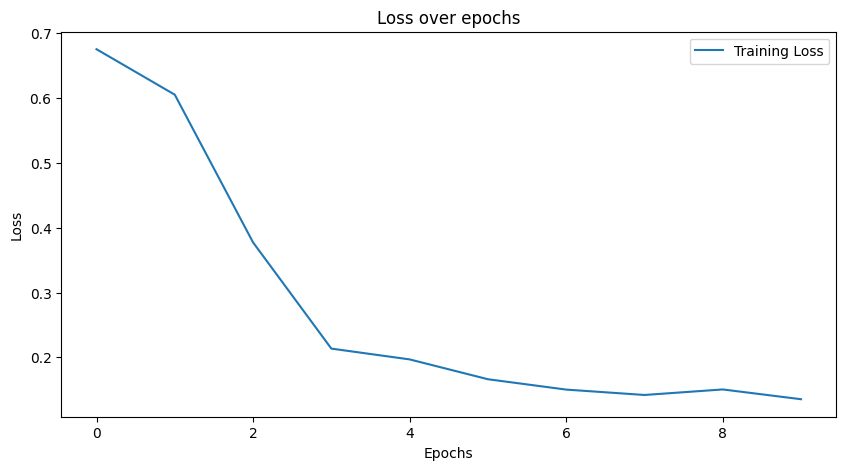

In [45]:
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Training Loss')
plt.title('Loss over epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Test the model using test data

In [46]:
test_image_folder = '/content/drive/MyDrive/Python Tutorial/crc1328-pythontutorial/data/UNetData/test/image'
test_mask_folder = '/content/drive/MyDrive/Python Tutorial/crc1328-pythontutorial/data/UNetData/test/mask'

max_samples = 100
test_dataset = CellSegmentationDataset(test_image_folder, test_mask_folder, transform=data_transform, max_samples=max_samples)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)


In [47]:
model.eval()  # Set the model to evaluation mode

all_predictions = []
all_masks = []

with torch.no_grad():  # No gradient computation during evaluation
    for images, masks in test_dataloader:
        images = images.to(device)
        masks = masks.to(device)

        outputs = model(images)
        predictions = torch.sigmoid(outputs)  # Apply sigmoid to get pixel-wise probabilities
        predictions = (predictions > 0.5).float()  # Binarize predictions

        all_predictions.append(predictions.cpu().numpy())
        all_masks.append(masks.cpu().numpy())


## Evaluate the model

Calculate dice coefficient

In [48]:
def dice_coefficient(y_true, y_pred):
    intersection = (y_true * y_pred).sum()
    return (2. * intersection + 1.) / (y_true.sum() + y_pred.sum() + 1.)

average_dice = np.mean([dice_coefficient(y_true, y_pred) for y_true, y_pred in zip(all_masks, all_predictions)])
print(f"Average Dice Coefficient: {average_dice:.4f}")


Average Dice Coefficient: 0.9209


Calculate confusion matrix

In [51]:
def confusion_matrix_values(y_true, y_pred):
    TP = (y_true * y_pred).sum()
    TN = ((1 - y_true) * (1 - y_pred)).sum()
    FP = ((1 - y_true) * y_pred).sum()
    FN = (y_true * (1 - y_pred)).sum()
    return TP, TN, FP, FN

In [52]:
TP_total, TN_total, FP_total, FN_total = 0, 0, 0, 0
for y_true, y_pred in zip(all_masks, all_predictions):
    TP, TN, FP, FN = confusion_matrix_values(y_true, y_pred)
    TP_total += TP
    TN_total += TN
    FP_total += FP
    FN_total += FN


In [53]:
conf_matrix = np.array([[TP_total, FP_total], [FN_total, TN_total]])
print(conf_matrix)


[[651316.  90032.]
 [ 20322. 876730.]]


calculate accuracy

In [55]:
accuracy = (TP_total + TN_total) / (TP_total + TN_total + FP_total + FN_total)
print(f"Accuracy: {accuracy:.4f}")


Accuracy: 0.9326


Visualize some predictions

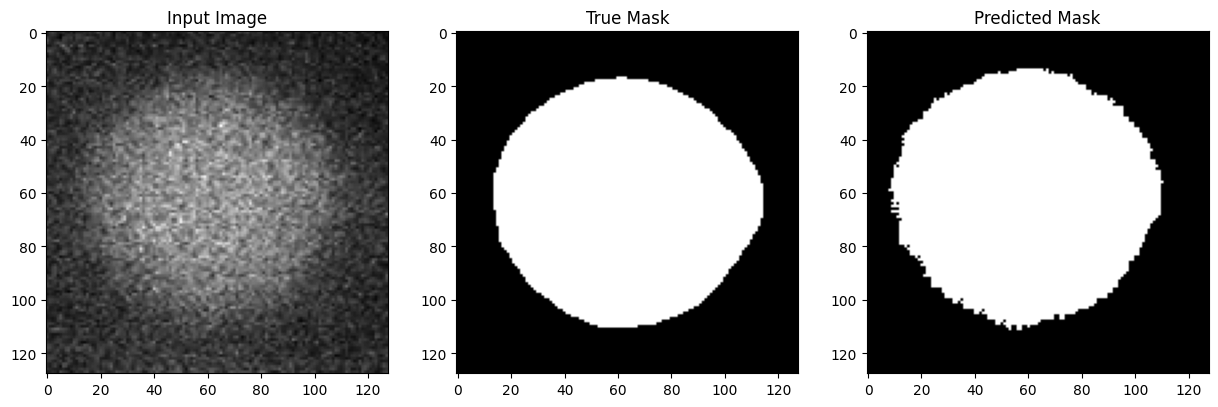

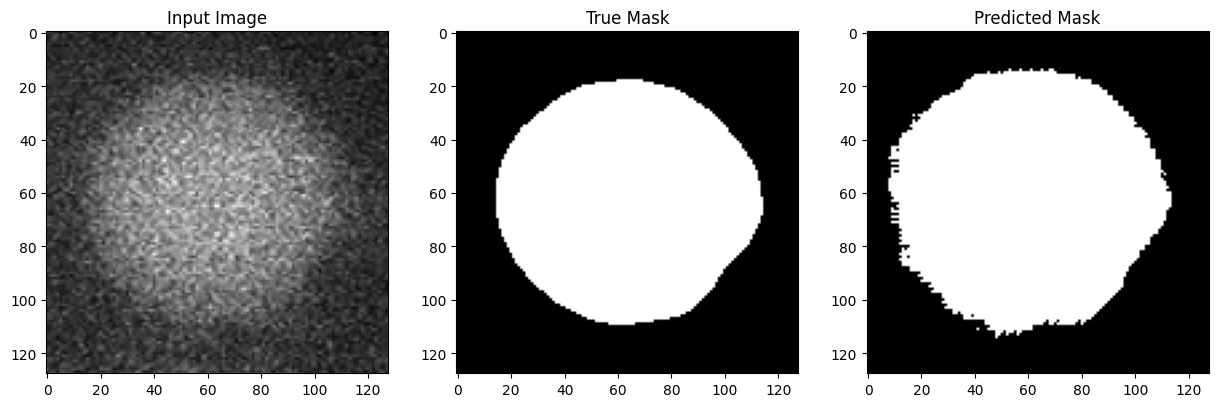

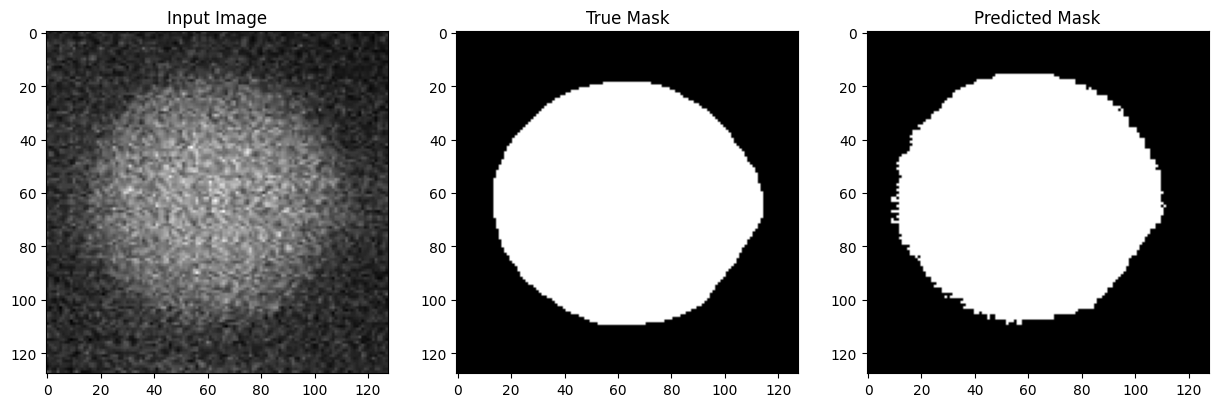

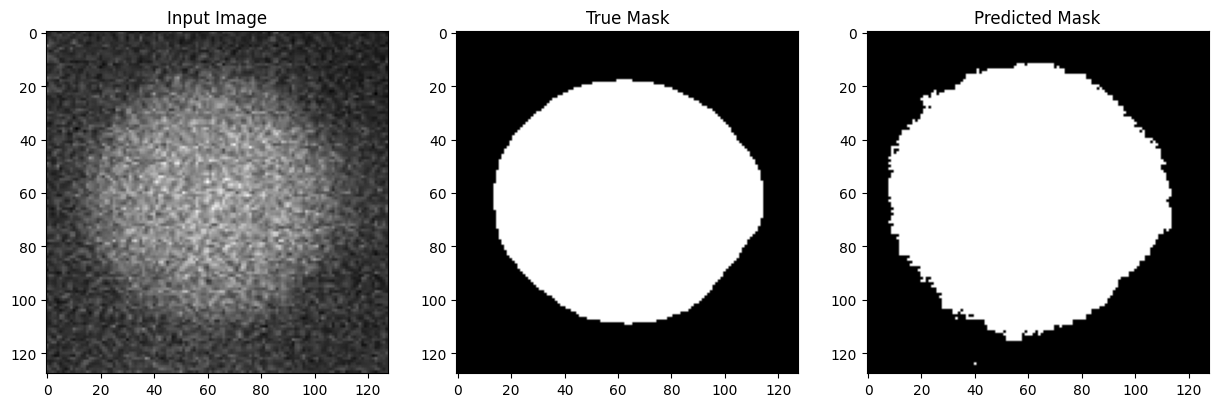

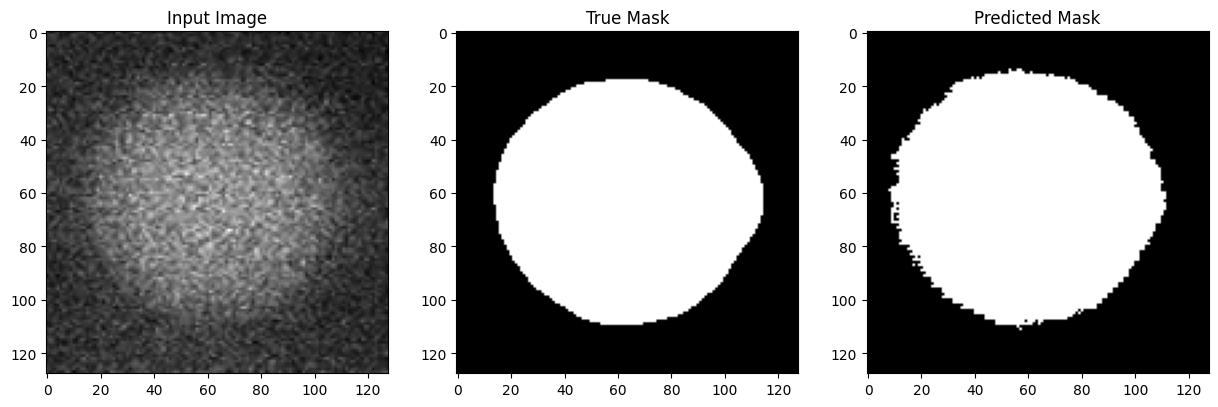

In [49]:
num_samples = 5
for i in range(num_samples):
    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.imshow(test_dataset[i][0].squeeze(0), cmap='gray')
    plt.title('Input Image')

    plt.subplot(1, 3, 2)
    plt.imshow(all_masks[i].squeeze(), cmap='gray')
    plt.title('True Mask')

    plt.subplot(1, 3, 3)
    plt.imshow(all_predictions[i].squeeze(), cmap='gray')
    plt.title('Predicted Mask')

    plt.show()
